### Generating Animated Map with `folium`

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Plugins.ipynb#Timestamped-GeoJSON

In [ ]:
import pandas as pd
import folium
from folium import plugins
import requests

pd.options.display.max_columns = None

In [ ]:
# df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/'
#                  'feed/v1.0/summary/2.5_day.csv')
df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/'
                 'feed/v1.0/summary/2.5_month.csv')

# df['time'] = pd.to_datetime(df['time'], utc=True)

df.head()

In [ ]:
# get faults
r = requests.get('https://raw.githubusercontent.com/'
                 'fraxen/tectonicplates/master/GeoJSON/'
                 'PB2002_boundaries.json')

fault_features = r.json()['features']

# for feature in fault_features:
#     feature['properties']['color'] = 'red'

In [ ]:
fault_features

In [ ]:
with open("./data/PB2002_boundaries.json", "r") as read_file:
    fault_feats = json.load(read_file)

In [ ]:
{"features": {"features": [{"geometry": {"coordinates": [[-0.4379, -54.8518], [-0.038826, -54.6772], [0.443182, -54.4512], [0.964534, -54.8322], [1.69481, -54.399], [2.35975, -54.0374], [3.02542, -53.6507], [3.36894, -53.8341], [3.95638, -54.1267], [4.41458, -54.4303], [4.82661, -54.1616], [5.08372, -54.3093], [5.49469, -54.5429], [6.18373, -54.1145], [6.6254, -53.8142], [7.23729, -54.1012], [7.77235, -54.396]], "type": "LineString"}, "properties": {"LAYER": "plate boundary", "Name": "AF-AN", "PlateA": "AF", "PlateB": "AN", "Source": "Mueller et al. [1987]", "Type": ""}, "type": 

In [ ]:
{
    'type': 'FeatureCollection',
    'features': fault_features,
}

In [ ]:
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [r['longitude'], r['latitude']],
        },
        'properties': {
            'time': r['time'][0:-1],
            'popup': (
                f"<strong>Time:</strong> {r['time']}<br>"
                f"<strong>Place:</strong> {r['place']}<br>"
                f"<strong>Magnitude:</strong> {r['mag']} {r['magType']}<br>"
                f"<strong>Depth:</strong> {r['depth']}<br>"
            ),
            'icon': 'circle',
            'iconstyle': {
                'fillOpacity': 0.5,
                'stroke': 0,
                'radius': r['mag'] * 2.5
            },
        }
    } for i, r in df.iterrows()
]

m = folium.Map(
#     location=()
    tiles='CartoDBpositron',
#     zoom_start=1,
#     no_wrap=True,
    min_zoom=1.5,
    max_zoom=5,
    world_copy_jump=True,
)

# add faults
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': fault_features,
    },
    style_function = lambda x: {
        'color': 'red',
        'weight': 0.5,
    }
).add_to(m)

plugins.TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT6H', # six hour
    time_slider_drag_update=True,
    duration='PT12H',
    date_options='YYYY-MM-DD HH UTC'
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    force_separate_button=True,
).add_to(m)

# m.save('earthquakes.html')
m

In [ ]:
# from IPython.display import IFrame
# IFrame('earthquakes_2.5_day.html', width='100%', height=500)

### Pulling Data from USGS

https://earthquake.usgs.gov/fdsnws/event/1/

In [ ]:
import requests
import pandas as pd
from io import StringIO

pd.options.display.max_columns = None

payload = {
    'format': 'csv', 
#     'starttime': None,  # default last 30 days
#     'endtime': '2019-06-03',  # default now
    'minmagnitude': 0,  # default null
    'limit': None,  # default null, returns 404 over 20,000
}
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
r = requests.get(url, params=payload)

r.url

df = pd.read_csv(StringIO(r.text))
print(df.shape)
df.head()

In [ ]:


if len(df) == 20000:
    # get most recent eathquake in DF
    # make a new request starting at last date
    df.append()

### Damage Data
from https://www.ngdc.noaa.gov/nndc/struts/form?t=101650&s=1&d=1

> The Significant Earthquake Database contains information on destructive earthquakes from 2150 B.C. to the present that meet at least one of the following criteria: 
> * Moderate damage (approximately $1 million or more)
> * 10 or more deaths
> * Magnitude 7.5 or greater
> * Modified Mercalli Intensity X or greater
> * the earthquake generated a tsunami

In [ ]:
dmg = pd.read_csv('https://www.ngdc.noaa.gov/nndc/struts/results?'
                  'type_0=Exact&query_0=$ID&t=101650&s=13&d=189&dfn=signif.txt',
                  sep='\t')

In [ ]:
dmg.describe()

### Contour Plot

One nice way to display likelihoods of earthquake, once we have them

https://www.tjansson.dk/2018/10/contour-map-in-folium/

In [ ]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
 
# Setup
temp_mean = 12
temp_std  = 2
debug     = False
 
# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
 
# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(11.84,     0.15,     1000),
    'latitude':    np.random.normal(55.55,     0.15,     1000),
    'temperature': np.random.normal(temp_mean, temp_std, 1000)})
 
# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.temperature.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
# geomap.save(f'data/folium_contour_temperature_map.html'
geomap

# Conclusions and Next Steps from Research

* Download ~20 years of data
* Group the world into regions - group by seismic properties? or a grid? do these seismic region groupings already exist?
* for each region, determine how complete USGS datasets are based on Gutenberg–Richter law and compute the cutoff

## Iteratively Download USGS Data

In [34]:
from dateutil.parser import parse
import requests
import pandas as pd
from io import StringIO

pd.options.display.max_columns = None

def dl_quake_data(start_date, end_date):
    start_date = parse(start_date).isoformat()
    end_date = parse(end_date).isoformat()
    payload = {
        'format': 'csv', 
        'starttime': start_date,
        'endtime': end_date,
        'minmagnitude': 2,
        'limit': 20000,
        'orderby': 'time-asc',
    }
    url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
    r = requests.get(url, params=payload)
    print(r.url, r.status_code)

    df = pd.read_csv(StringIO(r.text))
    
    dt_min = df['time'].iloc[0]
    dt_max = df['time'].iloc[-1]
    
    fn = (f'{parse(dt_min).strftime("%Y-%m-%d")}_'
          f'{parse(dt_max).strftime("%Y-%m-%d")}')
    df.to_csv(f'data/{fn}.csv', index=False)
    
    print(fn)
    
    if len(df) == 20000:
         dl_quake_data(start_date=dt_max,
                       end_date=end_date)
    
    return True

In [ ]:
%%time
dl_quake_data('2000-01-01', '2019-01-01')

In [6]:
from pathlib import Path

dfs = []
for csv in Path('data').iterdir():
    dfs.append(pd.read_csv(csv))
    
df = pd.concat(dfs)

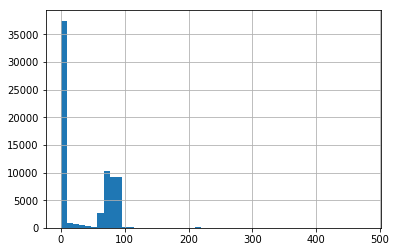

In [27]:
(pd.to_datetime(df['updated']) - pd.to_datetime(df['time'])).dt.days.hist(bins=50);

## Generate Earth Grid
https://en.wikipedia.org/wiki/Geographic_coordinate_system#3D_Cartesian_coordinates

**Potential Improvements:** 

* Define these regions algorithmically (like sklearn.clusters.DBSCAN, [clusterpy](https://github.com/clusterpy/), [Moran'sI](https://en.wikipedia.org/wiki/Moran's_I)) based on earthquake characteristics in the regions
* [Use extant domain research](https://www.researchgate.net/publication/260702383_A_detailed_seismic_zonation_model_for_shallow_earthquakes_in_the_broader_Aegean_area)

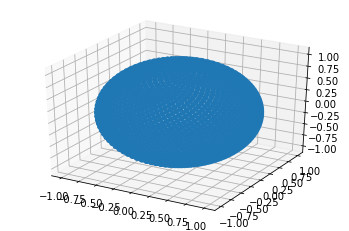

In [53]:
# roughly equidistant points on (cartesian) sphere
#https://stackoverflow.com/a/44164075/11208892
from numpy import pi, cos, sin, arccos, arange, arctan2, arcsin
import mpl_toolkits.mplot3d
import matplotlib.pyplot as pp

num_pts = 3000
indices = arange(0, num_pts, dtype=float) + 0.5

phi = arccos(1 - 2*indices/num_pts)
theta = pi * (1 + 5**0.5) * indices

x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi);

pp.figure().add_subplot(111, projection='3d').scatter(x, y, z);
pp.show();

In [54]:
# convert to lat/lon, ignoring that the earth is not a sphere
# https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
lats = (360 * arcsin(z / 1)) / (2 * pi)
lons = (360 * arctan2(y, x)) / (2 * pi)

In [56]:
# plot it
import folium

m = folium.Map(
    tiles='CartoDBpositron',
)

for lat, lon in zip(lats, lons):                                
    folium.CircleMarker([lat, lon], radius=1).add_to(m)

m.save('equidistant_pts.html')